In [ ]:
"""
You can run either this notebook locally (if you have all the dependencies and a GPU) or on Google Colab.

Instructions for setting up Colab are as follows:
1. Open a new Python 3 notebook.
2. Import this notebook from GitHub (File -> Upload Notebook -> "GITHUB" tab -> copy/paste GitHub URL)
3. Connect to an instance with a GPU (Runtime -> Change runtime type -> select "GPU" for hardware accelerator)
4. Run this cell to set up dependencies.
5. Restart the runtime (Runtime -> Restart Runtime) for any upgraded packages to take effect
"""
# If you're using Google Colab and not running locally, run this cell.

## Install dependencies
!pip install wget
!apt-get install sox libsndfile1 ffmpeg
!pip install unidecode
!pip install matplotlib>=3.3.2

## Install NeMo
BRANCH = 'v1.0.0'
!python -m pip install git+https://github.com/NVIDIA/NeMo.git@$BRANCH#egg=nemo_toolkit[all]

## Grab the config we'll use in this example
!mkdir configs
!wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/config.yaml

"""
Remember to restart the runtime for the kernel to pick up any upgraded packages (e.g. matplotlib)!
Alternatively, you can uncomment the exit() below to crash and restart the kernel, in the case
that you want to use the "Run All Cells" (or similar) option.
"""
# exit()

# Telephony speech (8 kHz)
This notebook covers general recommendations for using NeMo models with 8 kHz speech. All the pretrained models currently available through NeMo are trained with audio at 16 kHz. This means that if the original audio was sampled at a different rate, it's sampling rate was converted to 16 kHz through upsampling or downsampling. One of the common applications for ASR is to recognize telephony speech which typically consists of speech sampled at 8 kHz.


# Mixed sample rate
Most of the pretrained English models distributed with NeMo are trained with mixed sample rate data, i.e. the training data typically consists of data sampled at both 8 kHz and 16 kHz. As an example pretrained Citrinet model "stt_en_citrinet_1024" was trained with the following datasets. 
* Librispeech 960 hours of English speech
* Fisher Corpus
* Switchboard-1 Dataset
* WSJ-0 and WSJ-1
* National Speech Corpus - 1
* Mozilla Common Voice

Among these, Fisher and Switchboard datasets are conversational telephone speech datasets with audio sampled at 8 kHz while the other datasets were originally sampled at at least 16 kHz. Before training all the audio from Fisher and Switchboard datasets Because of this mixed sample rate training our models can be used to recognize both narrowband (8kHz) and wideband speech (16kHz).

# Inference with NeMo
NeMo ASR currently supports inference of audio in .wav format. Internally, the audio file is resampled to 16 kHz before inference is called on the model, so there is no difference running inference on 8 kHz audio compared to say 16 kHz or any other sampling rate audio with NeMo. Let's look at an example for running inference on 8 kHz audio. 

In [1]:
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = '.'

In [2]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'http://www.speech.cs.cmu.edu/databases/an4/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Tarfile already exists.
Finished conversion.
******


22050


(0.0, 8000.0)

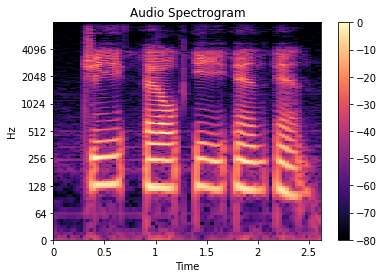

In [16]:
import librosa
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt

# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

audio_16kHz = librosa.core.resample(audio, sample_rate, 16000)
print(sample_rate)
import numpy as np

# Get spectrogram using Librosa's Short-Time Fourier Transform (stft)
spec = np.abs(librosa.stft(audio_16kHz))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time', sr=16000)
plt.colorbar()
plt.title('Audio Spectrogram');
plt.ylim([0, 8000])

Now, let's downsample the audio to 8 kHz

(0.0, 8000.0)

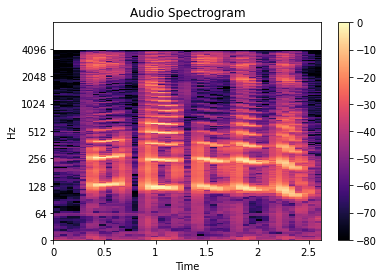

In [18]:
audio_8kHz = librosa.core.resample(audio, sample_rate, 8000)
spec = np.abs(librosa.stft(audio_8kHz))
spec_db = librosa.amplitude_to_db(spec, ref=np.max)  # Decibels

# Use log scale to view frequencies
librosa.display.specshow(spec_db, y_axis='log', x_axis='time',  sr=8000)
plt.colorbar()
plt.title('Audio Spectrogram');
plt.ylim([0, 8000])

In [29]:
import soundfile as sf
sf.write(data_dir + '/audio_16kHz.wav', audio_16kHz, 16000)
sf.write(data_dir + '/audio_8kHz.wav', audio_8kHz, 8000)

#Inference
Let's look at inference results using one of the pretrained models on the original, 16 kHz and 8 kHz versions of the example file we chose above.

In [ ]:
from nemo.collections.asr.models import ASRModel
import torch
if torch.cuda.is_available():
    device = torch.device(f'cuda:0')
asr_model = ASRModel.from_pretrained(model_name='stt_en_citrinet_1024', map_location=device)

As discussed above, there are no changes required for inference based on the sampling rate of audio and as we see below the pretrained Citrinet model gives accurate transcription even for audio downsampled to 8 Khz.

In [38]:
print(asr_model.transcribe(paths2audio_files=[example_file]))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['g l e n n']


In [35]:
print(asr_model.transcribe(paths2audio_files=[data_dir + '/audio_16kHz.wav']))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['g l e n n']


In [37]:
print(asr_model.transcribe(paths2audio_files=[data_dir + '/audio_8kHz.wav']))

Transcribing:   0%|          | 0/1 [00:00<?, ?it/s]

['g l e n n']


# Training / fine-tuning with 8 kHz data
For training a model with new 8 kHz data, one could take two approaches. The first approach which is recommended is to finetune a pretrained 16 kHz model by upsampling all the data to 16 kHz. Note that upsampling offline before training is not necessary but recommended as online upsampling during training is very tiem consuming and may slow down training significantly. The second approach is to train an 8 kHz model from scratch. Even for the second approach, in our experiments we saw that loading the weights of a 16 kHz model as initialization helps the model to converge faster with better accuracy.
#TODO example for training